# Using SVM to establish a baseline model to classify blood cells

This notebook uses a simple, machine learning model as our baseline model to compare our proposed neural network against. Our chosen model is the Support Vector Machines (SVM), which is a supervised machine learning algorithm that is commonly used for classification and regression problems 

For our baseline model, we are implementing a simple SVM using the Scikit-learn or sklearn libary. 

source: https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01 and

https://www.kaggle.com/code/prashant111/svm-classifier-tutorial

##Extracting The Small Dataset

The large dataset has been processed into a smaller dataset of randomly chosen 2000 images called the Blood_Cell_Dataset_Small_Split.zip. It contains 3 folders for training, validation and testing. We'll be first extracting the contents by unzipping before moving on to data processing for the input of the SVM.

In [1]:
# link to Raisa's Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
file_dir = '/content/drive/MyDrive/SVM/Blood_Cell_Dataset_Small_Split.zip'
extract_file_dir = '/content/drive/MyDrive/SVM/Small_Split_Extracted'

import zipfile
with zipfile.ZipFile(file_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_file_dir)

In [2]:
train_folder = '/content/drive/MyDrive/Demo/Small_Split_Extracted/content/Blood_Cell_Dataset_Small_Split/train'
val_folder = '/content/drive/MyDrive/Demo/Small_Split_Extracted/content/Blood_Cell_Dataset_Small_Split/val'
test_folder = '/content/drive/MyDrive/Demo/Small_Split_Extracted/content/Blood_Cell_Dataset_Small_Split/test'

In [3]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Test/Final_Test_Dataset.zip', 'r') #raisa's path
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
from skimage.io import imread
from sklearn.metrics import classification_report
import time
import torch
import torchvision
import torchvision.transforms as transforms

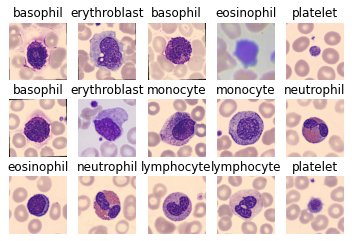

In [ ]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
        [transforms.Resize((360,360)), #resize all images to height and width of 360
         transforms.ToTensor(),        #transform images to tensors
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ('basophil', 'neutrophil', 'ig', 'monocyte', 
               'eosinophil', 'erythroblast', 'lymphocyte', 'platelet')

train_dataset = torchvision.datasets.ImageFolder(train_folder, transform=transform)

# Load data using DataLoader
batch_size = 1
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Visualizing some of the data (using Lab2 Part1.a. code)
k = 0
for images, labels in train_loader:
    #only one image in each batch
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(classes[labels[0]])

    k += 1
    if k > 14:
        break

The SVM takes a dataframe input. For the training dataset, it looks into the contents of the dataset and tries to find the weights that give the best fit to it given the true labels. 

In this section, we are turning the images into flattened arrays and converting them to a datafram at the end for the input (x) to the SVM and the expected output (y) from the SVM for each of the training, validation and testing datasets.

In [4]:
classes = ('basophil', 'neutrophil', 'ig', 'monocyte', 
               'eosinophil', 'erythroblast', 'lymphocyte', 'platelet')

train_flat_data_arr = []
train_target_arr = []

#prepare training input dataset

for category in classes:
  print('Loading category:', category)
  path = os.path.join(train_folder, category) #go into the category folder

  #loop over all the images in the category folder
  for i in os.listdir(path):
    img_arr = imread(os.path.join(path, i))
    img_resized = resize(img_arr, (200, 200, 3)) #resize all images to be square images of 200 x 200 with 3 channels
    train_flat_data_arr.append(img_resized.flatten())
    train_target_arr.append(classes.index(category))

  
  print('Loading category', category, 'sucessfull.')

Loading category: basophil
Loading category basophil sucessfull.
Loading category: neutrophil
Loading category neutrophil sucessfull.
Loading category: ig
Loading category ig sucessfull.
Loading category: monocyte
Loading category monocyte sucessfull.
Loading category: eosinophil
Loading category eosinophil sucessfull.
Loading category: erythroblast
Loading category erythroblast sucessfull.
Loading category: lymphocyte
Loading category lymphocyte sucessfull.
Loading category: platelet
Loading category platelet sucessfull.


In [5]:
train_flat_data = np.array(train_flat_data_arr)
train_target = np.array(train_target_arr)

df=pd.DataFrame(train_flat_data) #convert to a dataframe
df['Target'] = train_target #add a new column to the dataframe

x_train =df.iloc[:,:-1] #input data 
y_train =df.iloc[:,-1] #output data expected

df.shape

(1600, 120001)

In [6]:
val_flat_data_arr = []
val_target_arr = []

#prepare training input dataset

for category in classes:
  print('Loading category:', category)
  path = os.path.join(val_folder, category) #go into the category folder

  #loop over all the images in the category folder
  for i in os.listdir(path):
    img_arr = imread(os.path.join(path, i))
    img_resized = resize(img_arr, (200, 200, 3)) #resize all images to be square images of 200 x 200 with 3 channels
    val_flat_data_arr.append(img_resized.flatten())
    val_target_arr.append(classes.index(category))

  
  print('Loading category', category, 'sucessfull.')

Loading category: basophil
Loading category basophil sucessfull.
Loading category: neutrophil
Loading category neutrophil sucessfull.
Loading category: ig
Loading category ig sucessfull.
Loading category: monocyte
Loading category monocyte sucessfull.
Loading category: eosinophil
Loading category eosinophil sucessfull.
Loading category: erythroblast
Loading category erythroblast sucessfull.
Loading category: lymphocyte
Loading category lymphocyte sucessfull.
Loading category: platelet
Loading category platelet sucessfull.


In [7]:
val_flat_data = np.array(val_flat_data_arr)
val_target = np.array(val_target_arr)

df=pd.DataFrame(val_flat_data) #convert to a dataframe
df['Target'] = val_target #add a new column to the dataframe

x_val =df.iloc[:,:-1] #input data 
y_val =df.iloc[:,-1] #output data expected

df.shape

(200, 120001)

In [8]:
test_flat_data_arr = []
test_target_arr = []

#prepare training input dataset

for category in classes:
  print('Loading category:', category)
  path = os.path.join(test_folder, category) #go into the category folder

  #loop over all the images in the category folder
  for i in os.listdir(path):
    img_arr = imread(os.path.join(path, i))
    img_resized = resize(img_arr, (200, 200, 3)) #resize all images to be square images of 200 x 200 with 3 channels
    test_flat_data_arr.append(img_resized.flatten())
    test_target_arr.append(classes.index(category))

  print('Loading category', category, 'sucessfull.')

Loading category: basophil
Loading category basophil sucessfull.
Loading category: neutrophil
Loading category neutrophil sucessfull.
Loading category: ig
Loading category ig sucessfull.
Loading category: monocyte
Loading category monocyte sucessfull.
Loading category: eosinophil
Loading category eosinophil sucessfull.
Loading category: erythroblast
Loading category erythroblast sucessfull.
Loading category: lymphocyte
Loading category lymphocyte sucessfull.
Loading category: platelet
Loading category platelet sucessfull.


In [9]:
test_flat_data = np.array(test_flat_data_arr)
test_target = np.array(test_target_arr)

df=pd.DataFrame(test_flat_data) #convert to a dataframe
df['Target'] = test_target #add a new column to the dataframe

x_test =df.iloc[:,:-1] #input data 
y_test =df.iloc[:,-1] #output data expected

df.shape

(200, 120001)

There are 2000 images in total in the stratified dataset, out of which 1600 are in the training set, 200 in the validation set and 200 in the test set.

In [10]:
from sklearn.preprocessing import StandardScaler

#doing some more preprocessing
cols = x_train.columns
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train = pd.DataFrame(x_train, columns=cols)
x_val = pd.DataFrame(x_val, columns=cols)
x_test = pd.DataFrame(x_test, columns=cols)

##Main Baseline Model

From a wide range of architectures available in sklearn.svm, we are using the simplest form of a Support Vector Machine algorithm, the C-Support Vector Classification. The fit method is used to fit the SVM model according to the given training data. Then the predict method is used to perform classification on validation and test samples. 

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def train_SVC(model, train_x, train_y, val_x, val_y):
  start_time = time.time()

  model.fit(train_x, train_y) #fit classifier to training set
  y_val_pred = model.predict(val_x)  #make prediction for test cases
  end_time = time.time()

  #compute and print accuracy of the model
  print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(val_y, y_val_pred)))
  print('Time taken:', (end_time - start_time)/60, 'mins')
  print('The classification report for this model:')
  print(classification_report(val_y, y_val_pred))

def test_SVC(model, test_x, test_y):
  y_pred = model.predict(test_x)  #make prediction for test cases
  #compute and print accuracy of the model
  print('Model test accuracy score: {0:0.4f}'. format(accuracy_score(test_y, y_pred)))
  print('The classification report for this model:')
  print(classification_report(test_y, y_pred))

##Quantitative Testing


As per the documentation in (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html):
The default hyperparameters of the SVC are:
*  C = 1.0
*  kernel = 'rbf'
*  degree = 3 (for poly kernel)
*  gamma = 'scale', which is 1/n_features*X.var()
*  coef0 - 0.0 (for poly and sigmoid)
*  shrinking = True
*  probability = False
*  cache_size = 200
*  class_weight = None
*  tol = 1e-3
*  verbrose = False
*  max_iter = -1
*  decision_fucntion_shape = 'ovr'
*  break_ties = False
*  random_state = None

In [15]:
#Model with default hyperparameters
svc1 = SVC()

print('Training on SVC with default hyperparameters')
train_SVC(svc1, x_train, y_train, x_val, y_val)

Training on SVC with default hyperparameters
Model validation accuracy score: 0.7250
Time taken: 7.974897579352061 mins
The classification report for this model:
              precision    recall  f1-score   support

           0       0.67      0.64      0.65        25
           1       0.75      0.84      0.79        25
           2       0.55      0.44      0.49        25
           3       0.66      0.76      0.70        25
           4       0.86      0.76      0.81        25
           5       0.78      0.72      0.75        25
           6       0.57      0.68      0.62        25
           7       1.00      0.96      0.98        25

    accuracy                           0.73       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200



In [17]:
#Model with linear kernel
svc2 = SVC(kernel='linear')
print('Training on SVC with linear kernel')
train_SVC(svc2, x_train, y_train, x_val, y_val)
test_SVC(svc2, x_test, y_test)

Training on SVC with linear kernel
Model validation accuracy score: 0.7550
Time taken: 4.452034795284272 mins
The classification report for this model:
              precision    recall  f1-score   support

           0       0.69      0.72      0.71        25
           1       0.70      0.76      0.73        25
           2       0.48      0.40      0.43        25
           3       0.72      0.72      0.72        25
           4       0.88      0.88      0.88        25
           5       0.83      0.80      0.82        25
           6       0.71      0.80      0.75        25
           7       1.00      0.96      0.98        25

    accuracy                           0.76       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.75      0.76      0.75       200

Model test accuracy score: 0.7100
The classification report for this model:
              precision    recall  f1-score   support

           0       0.61      0.68      0.64        25
           1

In [18]:
#Model with rbf kernel
svc3 = SVC(kernel='rbf')
print('Training on SVC with rbf kernel')
train_SVC(svc3, x_train, y_train, x_val, y_val)

Training on SVC with rbf kernel
Model validation accuracy score: 0.7250
Time taken: 7.708963660399119 mins
The classification report for this model:
              precision    recall  f1-score   support

           0       0.67      0.64      0.65        25
           1       0.75      0.84      0.79        25
           2       0.55      0.44      0.49        25
           3       0.66      0.76      0.70        25
           4       0.86      0.76      0.81        25
           5       0.78      0.72      0.75        25
           6       0.57      0.68      0.62        25
           7       1.00      0.96      0.98        25

    accuracy                           0.73       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200



In [12]:
#Model with poly kernel
svc4 = SVC(kernel='poly')
print('Training on SVC with poly kernel')
train_SVC(svc4, x_train, y_train, x_val, y_val)

Training on SVC with poly kernel
Model validation accuracy score: 0.4950
Time taken: 9.3297323346138 mins
The classification report for this model:
              precision    recall  f1-score   support

           0       0.33      0.12      0.18        25
           1       0.24      0.96      0.38        25
           2       0.00      0.00      0.00        25
           3       0.78      0.28      0.41        25
           4       0.56      0.40      0.47        25
           5       0.78      0.56      0.65        25
           6       0.77      0.68      0.72        25
           7       1.00      0.96      0.98        25

    accuracy                           0.49       200
   macro avg       0.56      0.49      0.47       200
weighted avg       0.56      0.49      0.47       200



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
#Model with sigmoid kernel
svc5 = SVC(kernel='sigmoid')
print('Training on SVC with sigmoid kernel')
train_SVC(svc5, x_train, y_train, x_val, y_val)

Training on SVC with sigmoid kernel
Model validation accuracy score: 0.7100
Time taken: 4.285649522145589 mins
The classification report for this model:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        25
           1       0.84      0.84      0.84        25
           2       0.45      0.36      0.40        25
           3       0.55      0.48      0.51        25
           4       0.95      0.80      0.87        25
           5       0.79      0.76      0.78        25
           6       0.59      0.80      0.68        25
           7       1.00      0.96      0.98        25

    accuracy                           0.71       200
   macro avg       0.72      0.71      0.71       200
weighted avg       0.72      0.71      0.71       200



Running the Support Vector Classifier on different types of kernels, we can see that the best validation accuracy was obtained when a linear kernel was used. 

Therefore, I'll be choosing model svc2 as our final baseline model as it has the highest accuracy on validation and testing datasets, which contains images it has not seen before. 

#Qualitative Testing

In this section, we wanted to see how our final baseline model seemed to behave for specific classes only. We will be exploring the classes: basophil, neutrophil, and platelet. I will be using the test folder since it contains images the SVC was not trained upon.

In [ ]:
basophil_flat_data_arr = []
basophil_target_arr = []

neutrophil_flat_data_arr = []
neutrophil_target_arr = []

platelet_flat_data_arr = []
platelet_target_arr = []

#prepare training input dataset

for category in classes:
  if category == 'basophil' or category == 'neutrophil' or category == 'platelet':
    print('Loading category:', category)
    path = os.path.join(test_folder, category) #go into the category folder

    #loop over all the images in the category folder
    for i in os.listdir(path):
      img_arr = imread(os.path.join(path, i))
      img_resized = resize(img_arr, (200, 200, 3)) #resize all images to be square images of 200 x 200 with 3 channels

      if category == 'basophil':
        basophil_flat_data_arr.append(img_resized.flatten())
        basophil_target_arr.append(classes.index(category))
      
      elif category == 'neutrophil':
        neutrophil_flat_data_arr.append(img_resized.flatten())
        neutrophil_target_arr.append(classes.index(category))
      
      elif category == 'platelet':
        platelet_flat_data_arr.append(img_resized.flatten())
        platelet_target_arr.append(classes.index(category))

    print('Loading category', category, 'sucessfull.')

Loading category: basophil
Loading category basophil sucessfull.
Loading category: neutrophil
Loading category neutrophil sucessfull.
Loading category: platelet
Loading category platelet sucessfull.


In [ ]:
basophil_flat_data = np.array(basophil_flat_data_arr)
basophil_target = np.array(basophil_target_arr)
neutrophil_flat_data = np.array(neutrophil_flat_data_arr)
neutrophil_target = np.array(neutrophil_target_arr)
platelet_flat_data = np.array(platelet_flat_data_arr)
platelet_target = np.array(platelet_target_arr)

df=pd.DataFrame(basophil_flat_data) #convert to a dataframe
df['Target'] = basophil_target #add a new column to the dataframe
x_basophil =df.iloc[:,:-1] #input data 
y_basophil =df.iloc[:,-1] #output data expected

df=pd.DataFrame(neutrophil_flat_data) #convert to a dataframe
df['Target'] = neutrophil_target #add a new column to the dataframe
x_neutrophil =df.iloc[:,:-1] #input data 
y_neutrophil =df.iloc[:,-1] #output data expected

df=pd.DataFrame(platelet_flat_data) #convert to a dataframe
df['Target'] = platelet_target #add a new column to the dataframe
x_platelet =df.iloc[:,:-1] #input data 
y_platelet =df.iloc[:,-1] #output data expected

In [ ]:
#doing some more preprocessing
cols = x_basophil.columns
scaler = StandardScaler()

x_basophil = scaler.fit_transform(x_basophil)
x_neutrophil = scaler.transform(x_neutrophil)
x_platelet = scaler.transform(x_platelet)

x_basophil = pd.DataFrame(x_basophil, columns=cols)
x_neutrophil = pd.DataFrame(x_neutrophil, columns=cols)
x_platelet = pd.DataFrame(x_platelet, columns=cols)

In [ ]:
#testing the final Baseline Model chosen on specific classes only

y_pred_baso = svc2.predict(x_basophil)  #make prediction for test cases
acc_baso = accuracy_score(y_basophil, y_pred_baso)

y_pred_neutro = svc2.predict(x_neutrophil)  #make prediction for test cases
acc_neutro = accuracy_score(y_neutrophil, y_pred_neutro)

y_pred_plat = svc2.predict(x_platelet)  #make prediction for test cases
acc_plat = accuracy_score(y_platelet, y_pred_plat)

print('Accuracy for Basophil class:', acc_baso)
print('Accuracy for Neutrophil class:', acc_neutro)
print('Accuracy for Platelet class:', acc_plat)

Accuracy for Basophil class: 0.04
Accuracy for Neutrophil class: 0.2
Accuracy for Platelet class: 1.0


# New Dataset Testing
In this section we are investigating how the final baseline model (svc2) performs on images collected from various different sources. We collected 6 images for each class, thereby creating a new dataset consisting of 48 images.

In [17]:
new_test_flat_data_arr = []
new_test_target_arr = []

#prepare training input dataset

for category in classes:
  print('Loading category:', category)
  path = os.path.join('/tmp/content/Final_Test_Dataset', category) #go into the category folder

  #loop over all the images in the category folder
  for i in os.listdir(path):
    img_arr = imread(os.path.join(path, i))
    img_resized = resize(img_arr, (200, 200, 3)) #resize all images to be square images of 200 x 200 with 3 channels
    new_test_flat_data_arr.append(img_resized.flatten())
    new_test_target_arr.append(classes.index(category))

  print('Loading category', category, 'sucessfull.')

Loading category: basophil
Loading category basophil sucessfull.
Loading category: neutrophil
Loading category neutrophil sucessfull.
Loading category: ig
Loading category ig sucessfull.
Loading category: monocyte
Loading category monocyte sucessfull.
Loading category: eosinophil
Loading category eosinophil sucessfull.
Loading category: erythroblast
Loading category erythroblast sucessfull.
Loading category: lymphocyte
Loading category lymphocyte sucessfull.
Loading category: platelet
Loading category platelet sucessfull.


In [18]:
new_test_flat_data = np.array(new_test_flat_data_arr)
new_test_target = np.array(new_test_target_arr)

df=pd.DataFrame(new_test_flat_data) #convert to a dataframe
df['Target'] = new_test_target #add a new column to the dataframe

x_new_test =df.iloc[:,:-1] #input data 
y_new_test =df.iloc[:,-1] #output data expected

df.shape

(48, 120001)

In [19]:
#doing some more preprocessing
x_new_test = scaler.transform(x_new_test)
x_new_test = pd.DataFrame(x_new_test, columns=cols)

In [ ]:
test_SVC(svc2, x_new_test, y_new_test)

Model test accuracy score: 0.2292
The classification report for this model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.13      0.67      0.22         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.21      0.50      0.30         6
           6       0.00      0.00      0.00         6
           7       1.00      0.67      0.80         6

    accuracy                           0.23        48
   macro avg       0.17      0.23      0.17        48
weighted avg       0.17      0.23      0.17        48



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
